### Data Preprocessing

In [42]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 1. Load CIFAR-100 data
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# 2. One-hot encode the labels
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

# 3. Define preprocessing function (resize + normalize)
def preprocess(image, label):
    # image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 4. Shuffle training data before splitting
train_indices = np.arange(len(X_train))
np.random.shuffle(train_indices)

X_train = X_train[train_indices]
y_train = y_train[train_indices]

# 5. Compute split sizes
val_size = int(0.1 * len(X_train))
X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_train = X_train[val_size:]
y_train = y_train[val_size:]

# 6. Create tf.data.Dataset pipelines
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


### 8 CNN model design

In [ ]:
def cnn_model_8():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Block 4
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    # Classifier
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))

    return model


### Compile Model

In [44]:
# Instantiate and compile
model8 = cnn_model_8()
model8.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model8.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 3,327,108 (12.69 MB)

 Trainable params: 3,324,164 (12.68 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Save Filters Before training  

In [45]:
# Get only Conv2D layers from the model
conv_layers = [layer for layer in model8.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Access the first two Conv2D layers
first_conv_layer = conv_layers[0]
second_conv_layer = conv_layers[1]

# Save their filters before training
first_filters_before = first_conv_layer.get_weights()[0].copy()
second_filters_before = second_conv_layer.get_weights()[0].copy()

In [46]:
first_filters_before.shape, second_filters_before.shape,

((3, 3, 3, 32), (3, 3, 32, 32))

### Training

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model8.fit(train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.0515 - loss: 4.4997 - val_accuracy: 0.0950 - val_loss: 3.9011
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1610 - loss: 3.5023 - val_accuracy: 0.1972 - val_loss: 3.4690
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2413 - loss: 3.0434 - val_accuracy: 0.2484 - val_loss: 2.9960
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2998 - loss: 2.7153 - val_accuracy: 0.3196 - val_loss: 2.6475
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3395 - loss: 2.5132 - val_accuracy: 0.3948 - val_loss: 2.2674
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3800 - loss: 2.3291 - val_accuracy: 0.4252 - val_loss: 2.1542
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3992 - loss: 2.2310 - val_accuracy: 0.4438 - val_loss: 2.0634
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4246 - loss: 2.1281 -

### Test

In [48]:
test_loss, test_accuracy = model8.evaluate(test_dataset, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5667 - loss: 1.6090
Test accuracy: 0.5621


### Plot training and validation loss, training and validation accuracy.

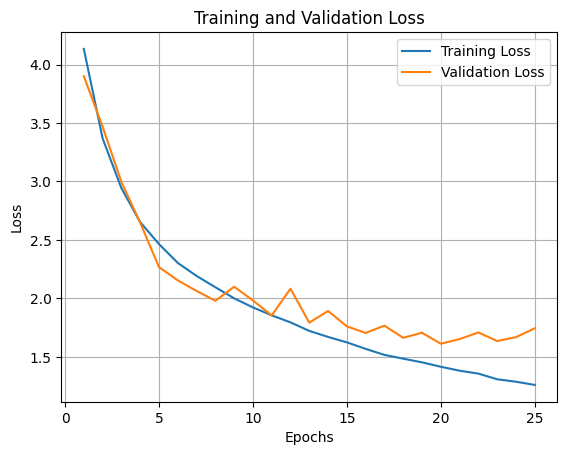

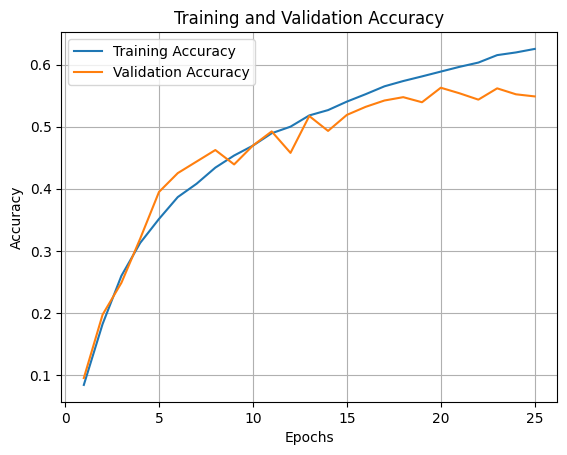

In [49]:
import matplotlib.pyplot as plt

# Extract data from training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Visualize convolutional filters before and after Training

In [50]:
first_filters_after = first_conv_layer.get_weights()[0]
second_filters_after = second_conv_layer.get_weights()[0]

first_filters_after.shape, second_filters_after.shape

((3, 3, 3, 32), (3, 3, 32, 32))

In [51]:
def visualize_rgb_filter_change(before, after, filter_index=0, layer_name='Conv1'):
    filter_before = before[:, :, :, filter_index]
    filter_after = after[:, :, :, filter_index]

    def normalize_filter(f):
        f_min, f_max = f.min(), f.max()
        return (f - f_min) / (f_max - f_min + 1e-8)

    filter_before = normalize_filter(filter_before)
    filter_after = normalize_filter(filter_after)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(filter_before)
    plt.title(f'{layer_name} - Filter {filter_index} (Before)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(filter_after)
    plt.title(f'{layer_name} - Filter {filter_index} (After)')
    plt.axis('off')

    plt.suptitle(f'{layer_name} - Filter {filter_index} Comparison')
    plt.tight_layout()
    plt.show()


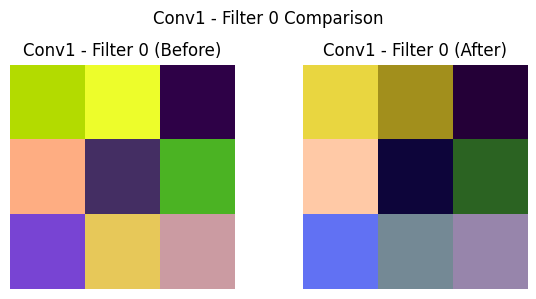

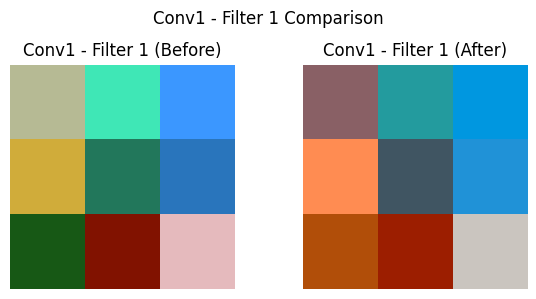

In [52]:
visualize_rgb_filter_change(first_filters_before, first_filters_after, filter_index=0, layer_name='Conv1')
visualize_rgb_filter_change(first_filters_before, first_filters_after, filter_index=1, layer_name='Conv1')


### Test Results

In [53]:
import numpy as np

y_true = []
y_pred = []

for batch in test_dataset:
    X_batch, y_batch = batch
    preds = model8.predict(X_batch)

    y_pred_batch = np.argmax(preds, axis=1)
    y_true_batch = np.argmax(y_batch.numpy(), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━

In [57]:
conf_matrix = confusion_matrix(y_true, y_pred)
num_classes = conf_matrix.shape[0]

# Initialize counts
TP_total = 0
FP_total = 0
FN_total = 0
TN_total = 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN


In [58]:
summary_table = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-score (macro)', 'True Positives', 'False Positives', 'False Negatives', 'True Negatives'],
    'Value': [round(accuracy_score(y_true, y_pred), 4),
              round(f1_score(y_true, y_pred, average='macro'), 4),
              TP_total, FP_total, FN_total, TN_total]
})

display(summary_table)


,Metric,Value
0,Accuracy,0.5621
1,F1-score (macro),0.5576
2,True Positives,5621.0000
3,False Positives,4379.0000
4,False Negatives,4379.0000
5,True Negatives,985621.0000


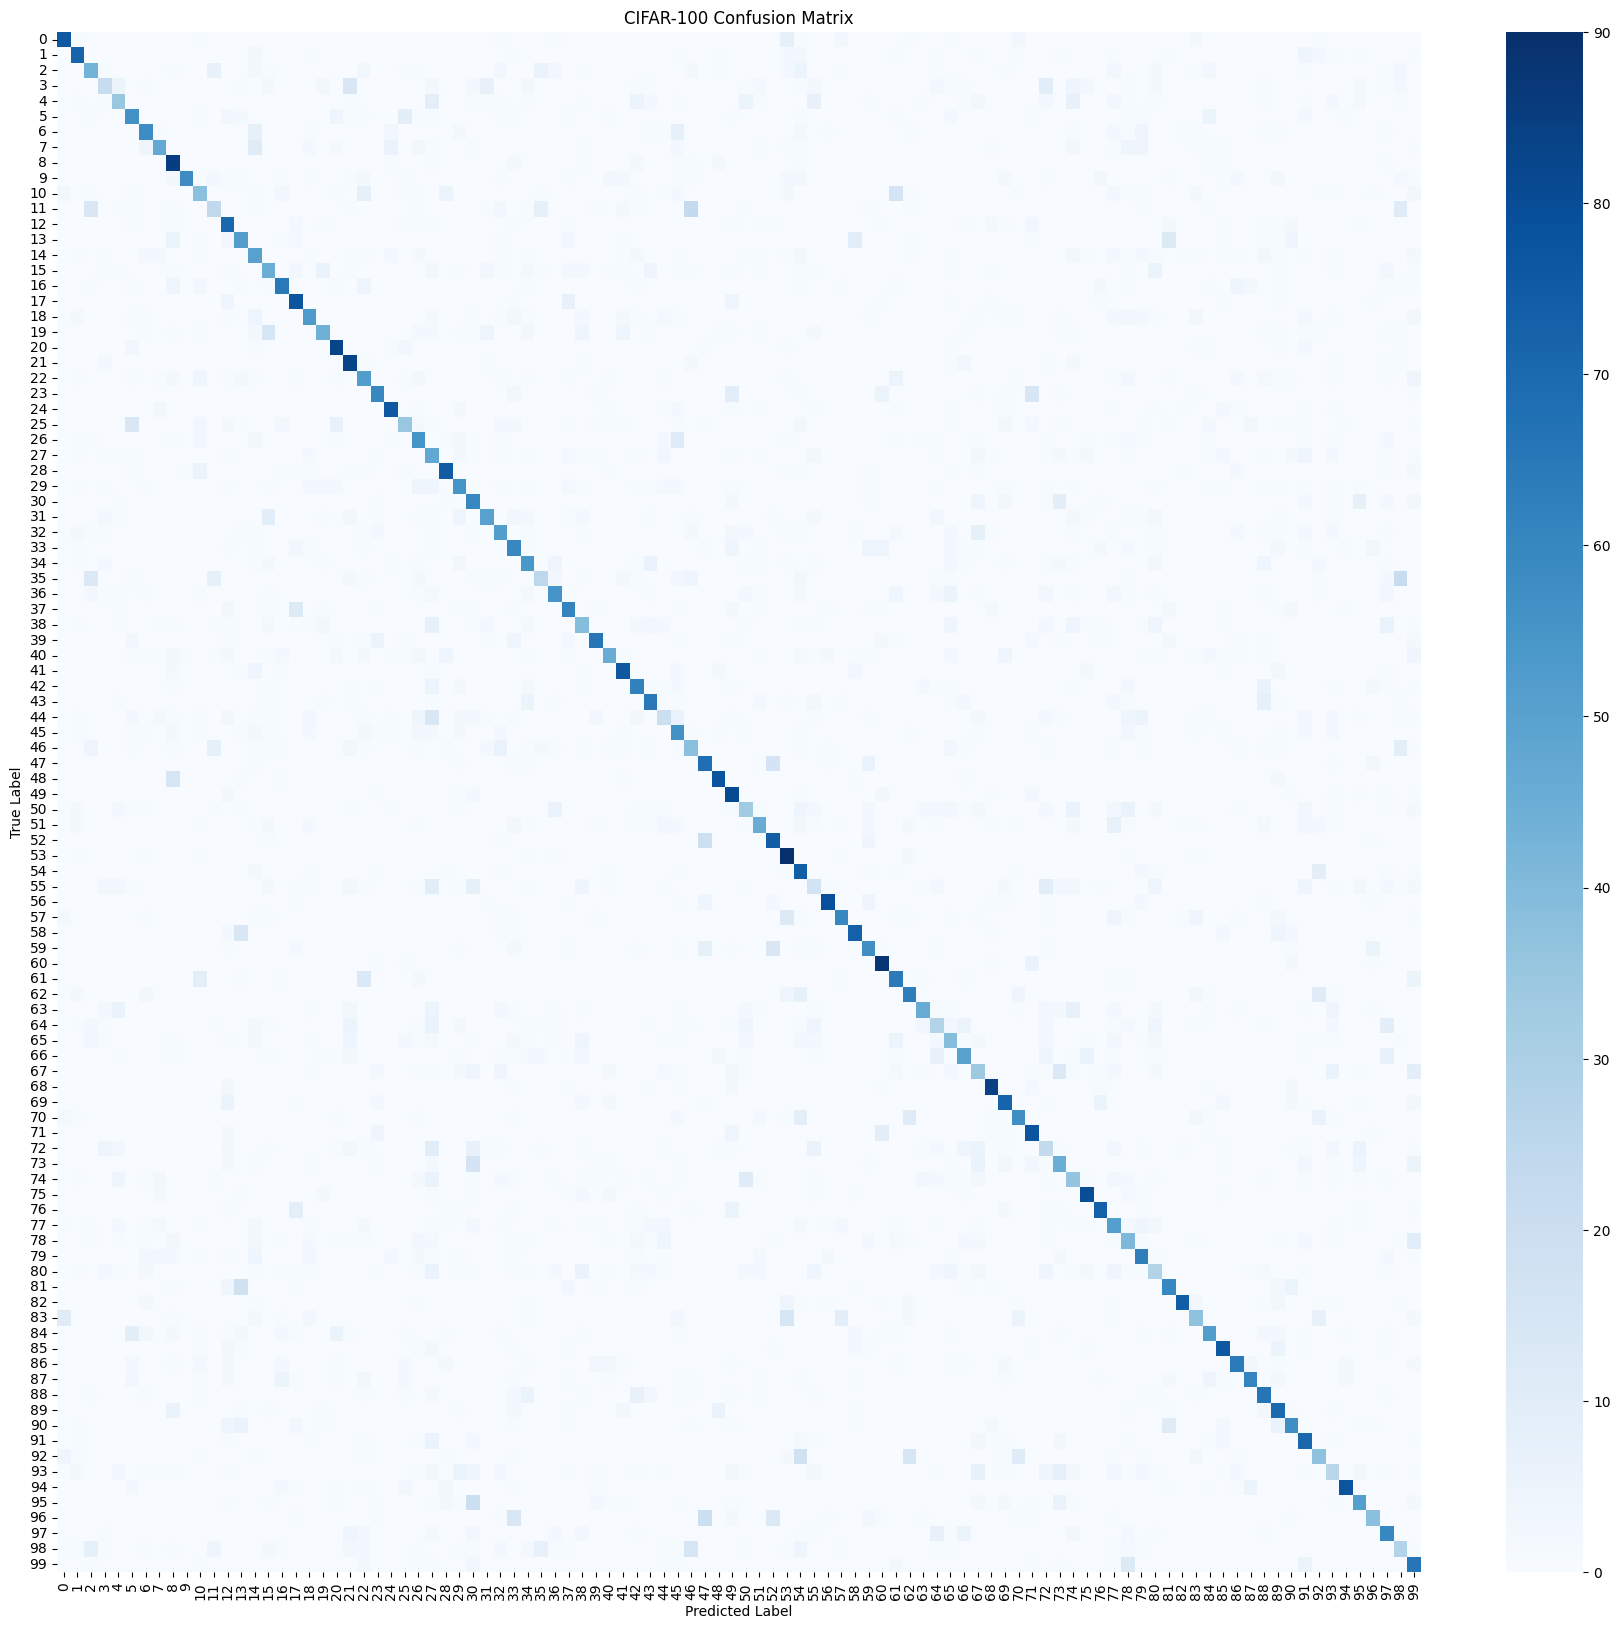

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)

class_labels = [str(i) for i in range(100)]

plt.figure(figsize=(22, 20))
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('CIFAR-100 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
